In [1]:
from cStringIO import StringIO
import numpy as np
import svgwrite
import random
import requests

from scipy.misc import imresize, imsave
from skimage.draw import line_aa

URL_DATA = {}
URL_DATA['aircraft-carrier-full'] = 'https://storage.googleapis.com/quickdraw_dataset/sketchrnn/aircraft%20carrier.full.npz'
URL_DATA['aircraft-carrier'] = 'https://storage.googleapis.com/quickdraw_dataset/sketchrnn/aircraft%20carrier.npz'
URL_DATA['anvil'] = 'https://storage.googleapis.com/quickdraw_dataset/sketchrnn/anvil.npz'

In [2]:
# download dataset
response = requests.get(URL_DATA['anvil'])
data = np.load(StringIO(response.content))
train_data = data['train']
print 'Loaded %d sketches' % (data['train'].shape[0])

Loaded 70000 sketches


In [3]:
# find the bounds of a single sketch
def get_bounds(data):
    min_x, max_x, min_y, max_y = (0, 0, 0, 0)
    abs_x, abs_y = (0, 0)
    for i in range(data.shape[0]):
        dx, dy = data[i, :2]
        abs_x += dx
        abs_y += dy
        min_x = min(min_x, abs_x)
        max_x = max(max_x, abs_x)
        min_y = min(min_y, abs_y)
        max_y = max(max_y, abs_y)
    return (min_x, max_x, min_y, max_y)

# convert strokes to bitmap
def strokes_to_npy(strokes):
    min_x, max_x, min_y, max_y = get_bounds(strokes)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    img = np.zeros(dims, dtype=np.uint8)
    abs_x = 25 - min_x
    abs_y = 25 - min_y
    pen_up = 1
    for i in range(strokes.shape[0]):
        dx, dy = strokes[i, :2]
        if pen_up == 0:
            rr, cc, val = line_aa(abs_x, abs_y, abs_x + dx, abs_y + dy)
            img[rr, cc] = val * 255
        abs_x += dx
        abs_y += dy
        pen_up = strokes[i, 2]
    return img.T

# fit in square box
def reshape_to_square(img, size=256):
    img_resize = imresize(img, float(size) / max(img.shape))
    w_, h_ = img_resize.shape
    x, y = ((size - w_) / 2, (size - h_) / 2)
    img_sq = np.zeros((size, size), dtype=np.uint8)
    img_sq[x:x + w_, y:y + h_] = img_resize
    return img_sq

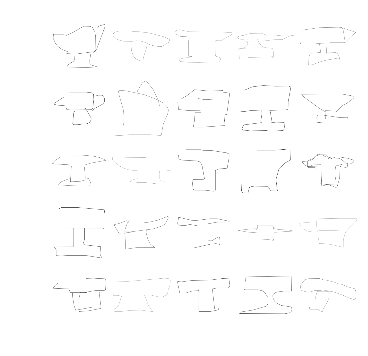

In [4]:
# plot the image
import matplotlib.pyplot as plt
%matplotlib inline

sketches = np.random.choice(train_data, size=25, replace=False)
img_grid = np.zeros(shape=(256 * 5, 256 * 5),dtype=np.uint8)
for i in range(5):
    for j in range(5):
        x, y = (256 * i, 256 * j)
        img_grid[x:x+256, y:y+256] = reshape_to_square(strokes_to_npy(sketches[5 * i + j]), 256)
        
plt.imshow(255 - img_grid, cmap='gray')
plt.axis('off')
plt.show()

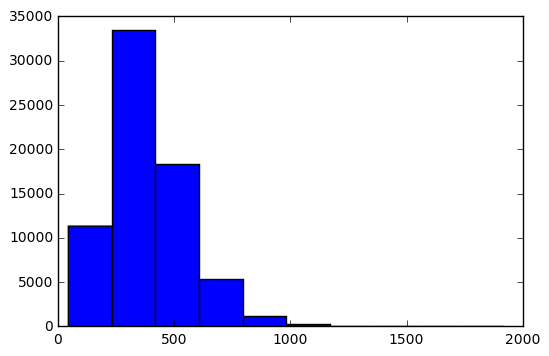

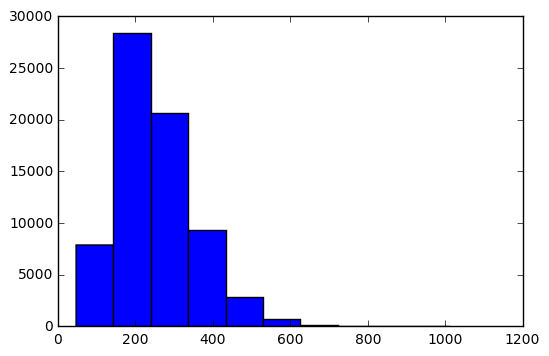

In [5]:
# plot a histogram of heights and widths of sketches
anvils = data['train']
anvil_dims = [get_bounds(a) for a in anvils]
anvil_wh = np.array([[x[1]-x[0], x[3]-x[2]] for x in anvil_dims])

plt.hist(anvil_wh[:, 0])
plt.show()
plt.hist(anvil_wh[:, 1])
plt.show()

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


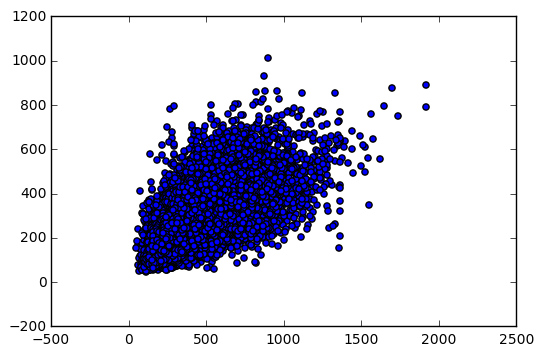

In [6]:
# plotting w, h scatter plot
plt.scatter(anvil_wh[:, 0], anvil_wh[:, 1])
plt.show()